# Calculo de la distribucion de tiempos en comun

En este notebook se genera un informe sobre la distribucion de tiempos
en comun que pueden tener las observaciones hermanas.

Consideraciones:

- Nos interesa los tiempos relativos a la observacion. Por eso se usa los MJD
- Dado que los MJD son unicos al pawprint para lograr mayor eficiencia de computo
  se utilizan los ID de los pawprint para contar

In [1]:
import sys
import os
import gc
import itertools as it
import tempfile
from collections import Counter

import numpy as np
import pandas as pd

from joblib import Parallel, delayed, cpu_count, load, dump, Memory

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# corral startup
sys.path.insert(1, "/home/jbcabral/carpyncho3")
os.environ.setdefault("CORRAL_SETTINGS_MODULE", "carpyncho.settings")

from corral import core
core.setup_environment()

from corral import db
from carpyncho.models import LightCurves

/home/jbcabral/.conda/envs/carpyncho3/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
with db.session_scope() as session:
    lc = session.query(LightCurves).filter(LightCurves.tile.has(name="b396")).one()
    obs_counter = lc.obs_counter
    observations = lc.observations

[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,985] select version()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,987] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,992] select current_schema()
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,994] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,998] SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:09,999] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:10,002] SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:10,003] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:10,008] show standard_conforming_strings
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:10,010] {}
[carpyncho-sqlalchemy.engine.base.Engine-INFO@2018-09-19 22:10:10,014] BEGIN (imp

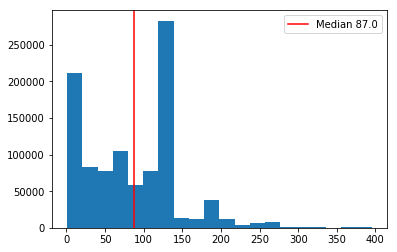

In [4]:
median = np.percentile(obs_counter["cnt"], 50)
ax = plt.gca()
ax.hist(obs_counter["cnt"], bins=20);
ax.axvline(median, color="r", label="Median " + str(median))
ax.legend()

In [5]:
obs_min = np.random.choice(
    obs_counter[obs_counter["cnt"] >= 87]["id"], 5000, False)
df = pd.DataFrame(observations[['bm_src_id', u'pwp_id', 'pwp_stack_src_mag3']])
df = df[df.bm_src_id.isin(obs_min)]

In [6]:
%time groups = df.groupby("bm_src_id")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 480 µs


In [7]:
means = groups.pwp_stack_src_mag3.mean()

In [8]:
df["mean_mag"] = df.bm_src_id.apply(lambda k: means[k])

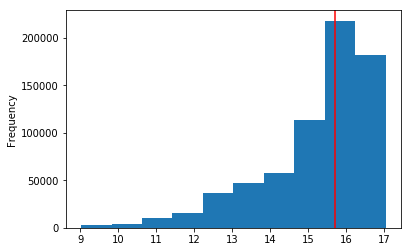

In [9]:
ax = df.mean_mag.plot.hist()
median = df.mean_mag.median()
ax.axvline(median, color="r")

In [10]:
obs_min = np.unique(df[df.mean_mag > median].bm_src_id.values)
if len(obs_min) > 1000:
    obs_min = np.random.choice(obs_min, 1000, False)
    df = df[df.bm_src_id.isin(obs_min)]
%time groups = df.groupby("bm_src_id")

CPU times: user 1e+03 µs, sys: 0 ns, total: 1e+03 µs
Wall time: 427 µs


In [11]:
temp_folder = "./cache"
filename = os.path.join(temp_folder, 'groups.mmap')
dump(groups, filename)
groups = load(filename, mmap_mode='r+')

In [12]:
%time combinations = tuple(it.combinations(obs_min, 2))

CPU times: user 302 ms, sys: 18 ms, total: 320 ms
Wall time: 320 ms


In [13]:
%time split_combs = np.array_split(combinations, 100)

CPU times: user 435 ms, sys: 0 ns, total: 435 ms
Wall time: 435 ms


In [14]:
import multiprocessing as mp
import datetime as dt
import gc

class NbgCalc(mp.Process):
    
    def __init__(self, idx, total, combs, groups):
        super(NbgCalc, self).__init__()
        self.idx = idx
        self.total = total
        self.combs = combs
        self.groups = groups
        self.size = len(combs)
        self._cache = {}
        self.queue = mp.Queue()
        
    def get_group(self, k):
        if k not in self._cache:
            self._cache[k] = frozenset(self.groups.get_group(k)["pwp_id"].values)
        return self._cache[k]
        
    def run(self):
        start = dt.datetime.now()
        print("[{}] Starting {}/{} with {} combs".format(
            start, self.idx, self.total, self.size))
        cnt = Counter()
        for k1, k2 in self.combs:
            g1, g2 = self.get_group(k1), self.get_group(k2)
            intersection = len(g1.intersection(g2))
            cnt.update([intersection])
        end = dt.datetime.now()
        
        print("[{}] Done {}/{}".format(end, self.idx, self.total))
        
        values_sum = sum(cnt.values())
        if values_sum != self.size:
            ex = ValueError("Combs {}/{} with diferent result sizes {} != {}".format(
                self.idx, self.total, self.size, values_sum))
            self.queue.put(ex)
        else:
            self.queue.put(cnt)
        
    def result(self):
        return self.queue.get()

def serialize(combs_chunks):
    serialized, total = [], len(combs_chunks)
    for idx, combs in enumerate(combs_chunks):
        combs = np.array(list(combs))
        fname = 'combs_{}.mmap'.format(idx)
        filename = os.path.join(temp_folder, fname)
        dump(combs, filename)
        combs = load(filename, mmap_mode='r+')
        print("[{}] {}/{} serialized".format(dt.datetime.now(), idx, total))
        yield idx, combs
    
total = cpu_count()
results, lens = [], []
for comb_group in split_combs:
    procs = []
    for idx, for_cpu in enumerate(np.array_split(comb_group, total)):
        lens.append(len(for_cpu))
        proc = NbgCalc(idx=idx, combs=for_cpu, total=total, groups=groups)
        proc.start()
        procs.append(proc)
    for proc in procs:
        proc.join()
        presult = proc.result()
        results.append(presult)
    del procs

[2018-09-19 22:11:52.622521] Starting 0/48 with 105 combs
[2018-09-19 22:11:52.640260] Starting 1/48 with 105 combs
[2018-09-19 22:11:52.660534] Starting 2/48 with 105 combs
[2018-09-19 22:11:52.680218] Starting 3/48 with 104 combs
[2018-09-19 22:11:52.698502] Starting 4/48 with 104 combs
[2018-09-19 22:11:52.719570] Starting 5/48 with 104 combs
[2018-09-19 22:11:52.739528] Starting 6/48 with 104 combs
[2018-09-19 22:11:52.764355] Starting 7/48 with 104 combs
[2018-09-19 22:11:52.786156] Done 0/48
[2018-09-19 22:11:52.797142] Starting 8/48 with 104 combs
[2018-09-19 22:11:52.817480] Done 1/48
[2018-09-19 22:11:52.823178] Done 2/48
[2018-09-19 22:11:52.828305] Starting 9/48 with 104 combs
[2018-09-19 22:11:52.840999] Done 3/48
[2018-09-19 22:11:52.859306] Starting 10/48 with 104 combs
[2018-09-19 22:11:52.863914] Done 4/48
[2018-09-19 22:11:52.882937] Done 5/48
[2018-09-19 22:11:52.894344] Starting 11/48 with 104 combs
[2018-09-19 22:11:52.903045] Done 6/48
[2018-09-19 22:11:52.928607] 

### Store the result to continue in another notebook

In [15]:
import pickle
with open("./data/count_high.pkl", "w") as fp:
    pickle.dump(results, fp)